In [2]:
import numpy as np
from Alak2 import Alak
import pickle as pkl
from tqdm import tqdm

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

# PART I

## Unit Test

In [2]:
# Attack side
off_side = ['x', 'x', 'x', 'x', 'o', 'o', 'o', 'o']
# Test case board positions
board_list = ['xoxoxx________', 'xooxooxx______','__xoo__oxo____','__xoooox_o____','_o__ooxxxo__o_',\
              '___xoxxxoo____','___x_oxxoo_____','____xoxx___x___']
# Expected boad positions
board_expect = ['x_x_xx________','x__x__xx______','__xoo__o_o____','__x____x_o____',\
                '_o__oo___o__o_', '___xo___oo____','___x_o__oo_____','____x_xx___x___']
# Map Pick and Attack position as per the soln
map_pos = {0:(6,2), 1:(8,3), 2:(0,8), 3:(0,7), 4:(0,5), 5:(0,4), 6:(0,5), 7:(0,5)}

# Create an object for Alak
alak_board_test = Alak()
# Check for wrong outputs
for board, off, key, expect in zip(board_list, off_side, map_pos, board_expect):
    res = ''.join(alak_board_test.check_cases(list(board), off, map_pos[key]))
    assert expect==res

## Playing the Model

In [3]:
alak = Alak(verbose=False)

In [ ]:
# Save the Games
summary = []
n_games =100000
save_data=(True, False)
data_x, data_o = np.zeros((1,29)), np.zeros((1,29))
for _ in tqdm(range(n_games)):
    cur_winner, cur_rounds, cur_x, cur_o = alak.play(save_data=save_data)
    if cur_rounds<=50:
        summary.append((cur_winner, cur_rounds))
        if cur_x != []:
            data_x = np.vstack([data_x, cur_x])
        if cur_o != []:
            data_o = np.vstack([data_o, cur_o])

##### NOTE : if the game get's stuck on some game because of really long rounds just restart the kernel and rerun the cell. This is rare but does happen!!!

In [6]:
data_x.shape, data_o.shape

((508944, 29), (1, 29))

In [7]:
np.unique(data_x[1:,-1],return_counts=True)

(array(['0', '1', '2', '3', '4', '5'], dtype='<U32'),
 array([342709, 118784,  30536,  10706,   4867,   1341]))

In [8]:
np.unique(data_o[1:,-1],return_counts=True)

(array([], dtype=float64), array([], dtype=int64))

In [10]:
def encode_data(X_org, y_org, encoding):
    X = X_org.copy()
    X[X=='x']=encoding[0]
    X[X=='o']=encoding[1]
    X[X=='_']=encoding[2]
    X=X.astype(float)
    
    y_org=y_org.astype(int)
    return X,y_org

### Saving games for 'x'

In [9]:
# Data shape after removing first row as it contains dummy data
X_x, y_x = data_x[1:,:-1],data_x[1:,-1]
print(f'Shape X : {X_x.shape}, y :{y_x.shape}')

Shape X : (508943, 28), y :(508943,)


In [11]:
# Encoding the data
encoding=[1,-1,0]
X_enc, y_enc = encode_data(X_x, y_x, encoding)
X_enc.shape, y_enc.shape

((508943, 28), (508943,))

In [12]:
idx=276
X_enc[idx], y_enc[idx]

(array([ 1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  1., -1.,
         0.,  1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  1.,  0.,  0.,  0.,
        -1.,  0.]),
 0)

In [13]:
data_x[idx+1]

array(['x', '_', '_', '_', '_', '_', 'o', '_', '_', '_', '_', 'x', 'o',
       '_', 'x', '_', '_', '_', '_', '_', 'o', '_', 'x', '_', '_', '_',
       'o', '_', '0'], dtype='<U32')

In [14]:
# Saving the data
np.save('data/X_x.npy', X_enc)
np.save('data/y_x.npy', y_enc)

### Saving games for 'o'

In [15]:
# Data shape after removing first row as it contains dummy data
X_o, y_o = data_o[1:,:-1],data_o[1:,-1]
print(f'Shape X : {X_o.shape}, y :{y_o.shape}')

Shape X : (0, 28), y :(0,)


In [16]:
# Encoding the data
encoding=[-1,1,0]
X_enc, y_enc = encode_data(X_o, y_o, encoding)
X_enc.shape, y_enc.shape

/var/folders/q6/43vsmv9x2pz_q1psr6pkrlyh0000gn/T/ipykernel_1011/3450343866.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  X[X=='x']=encoding[0]
/var/folders/q6/43vsmv9x2pz_q1psr6pkrlyh0000gn/T/ipykernel_1011/3450343866.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  X[X=='o']=encoding[1]
/var/folders/q6/43vsmv9x2pz_q1psr6pkrlyh0000gn/T/ipykernel_1011/3450343866.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  X[X=='_']=encoding[2]


((0, 28), (0,))

In [17]:
idx=1
X_enc[idx], y_enc[idx]

IndexError: index 1 is out of bounds for axis 0 with size 0

In [ ]:
# Saving the data
np.save('data/X_o.npy', X_enc)
np.save('data/y_o.npy', y_enc)

## Loading the respective data and training the model

### Training Model 'o'

In [27]:
# Load the data
X, y = np.load('data/X_o.npy'), np.load('data/y_o.npy')

In [28]:
# Split the data into training and testing
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)
x_train.shape, x_test.shape

((22412, 28), (2491, 28))

In [29]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5])

### Tensorflow Training

In [22]:
# Metrices to monitor
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

Metal device set to: Apple M1


2023-05-18 04:37:28.669049: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-18 04:37:28.670861: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [23]:
def make_model(metrics=METRICS):
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(180, activation='relu', input_shape=(28,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6,activation='softmax')])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=metrics)
    return model

In [33]:
# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    verbose=1,
                    patience=10,
                    mode='min',
                    restore_best_weights=True)
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 180)               5220      
                                                                 
 dense_1 (Dense)             (None, 64)                11584     
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 17,194
Trainable params: 17,194
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Convert y into categories
y_train_cat, y_test_cat = to_categorical(y_train,6), to_categorical(y_test,6)
y_train_cat.shape, y_test_cat.shape

((22412, 6), (2491, 6))

In [40]:
# Adding class weights
total = y_train.shape[0]
count_0 = y_train[y_train==0].shape[0]
count_1 = y_train[y_train==1].shape[0]
count_2 = y_train[y_train==2].shape[0]
count_3 = y_train[y_train==3].shape[0]
count_4 = y_train[y_train==4].shape[0]
count_5 = y_train[y_train==5].shape[0]

weight_for_0 = (1/count_0)*(total/2.0)
weight_for_1 = (1/count_1)*(total/2.0)
weight_for_2 = (1/count_2)*(total/2.0)
weight_for_3 = (1/count_3)*(total/2.0)
weight_for_4 = (1/count_4)*(total/2.0)
weight_for_5 = (1/count_5)*(total/2.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2,
                3: weight_for_3, 4: weight_for_4, 5: weight_for_5}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))
print('Weight for class 4: {:.2f}'.format(weight_for_4))
print('Weight for class 5: {:.2f}'.format(weight_for_5))

Weight for class 0: 0.75
Weight for class 1: 2.13
Weight for class 2: 7.54
Weight for class 3: 24.20
Weight for class 4: 59.61
Weight for class 5: 189.93


In [41]:
# Train the model
EPOCHS = 10
history = model.fit(
            x_train,
            y_train_cat,
            batch_size=32,
            epochs=EPOCHS,
            callbacks=[early_stopping],
            validation_data=(x_test,y_test_cat),
            class_weight=class_weight)

Epoch 1/50


2023-05-15 18:44:28.707544: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-15 18:44:29.388950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


701/701 [==============================] - ETA: 0s - loss: 3.4498 - tp: 7502.0000 - fp: 984.0000 - tn: 111076.0000 - fn: 14910.0000 - categorical_accuracy: 0.6154 - precision: 0.8840 - recall: 0.3347 - auc: 0.9104 - prc: 0.7150

2023-05-15 18:44:49.157713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


701/701 [==============================] - 22s 30ms/step - loss: 3.4498 - tp: 7502.0000 - fp: 984.0000 - tn: 111076.0000 - fn: 14910.0000 - categorical_accuracy: 0.6154 - precision: 0.8840 - recall: 0.3347 - auc: 0.9104 - prc: 0.7150 - val_loss: 0.6171 - val_tp: 1626.0000 - val_fp: 205.0000 - val_tn: 12250.0000 - val_fn: 865.0000 - val_categorical_accuracy: 0.8057 - val_precision: 0.8880 - val_recall: 0.6527 - val_auc: 0.9724 - val_prc: 0.8854
Epoch 2/50
701/701 [==============================] - 20s 28ms/step - loss: 1.3234 - tp: 18968.0000 - fp: 1192.0000 - tn: 110868.0000 - fn: 3444.0000 - categorical_accuracy: 0.9045 - precision: 0.9409 - recall: 0.8463 - auc: 0.9933 - prc: 0.9693 - val_loss: 0.2074 - val_tp: 2370.0000 - val_fp: 58.0000 - val_tn: 12397.0000 - val_fn: 121.0000 - val_categorical_accuracy: 0.9683 - val_precision: 0.9761 - val_recall: 0.9514 - val_auc: 0.9990 - val_prc: 0.9952
Epoch 3/50
701/701 [==============================] - 20s 28ms/step - loss: 0.4915 - tp: 2212

In [49]:
model.save('model_o_tf.h5')

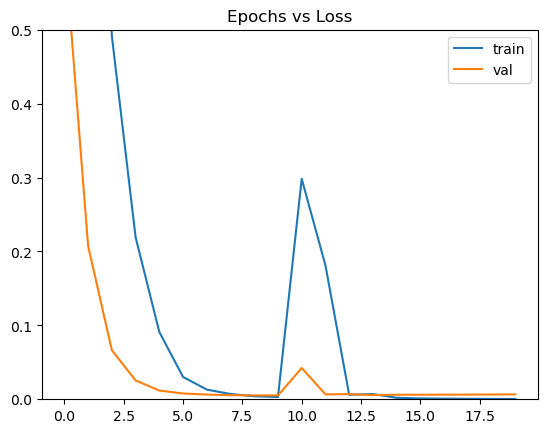

In [46]:
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='train')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label='val')
plt.title('Epochs vs Loss')
plt.ylim([0,0.5])
plt.legend()

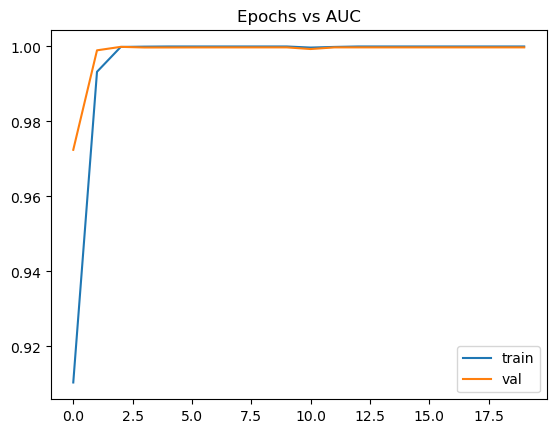

In [47]:
plt.plot(range(len(history.history['auc'])), history.history['auc'], label='train')
plt.plot(range(len(history.history['val_auc'])), history.history['val_auc'], label='val')
plt.title('Epochs vs AUC')
plt.legend()

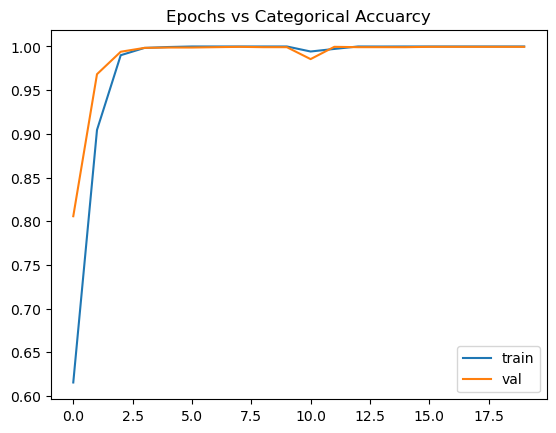

In [48]:
plt.plot(range(len(history.history['categorical_accuracy'])), history.history['categorical_accuracy'], label='train')
plt.plot(range(len(history.history['val_categorical_accuracy'])), history.history['val_categorical_accuracy'], label='val')
plt.title('Epochs vs Categorical Accuarcy')
plt.legend()

<Axes: >

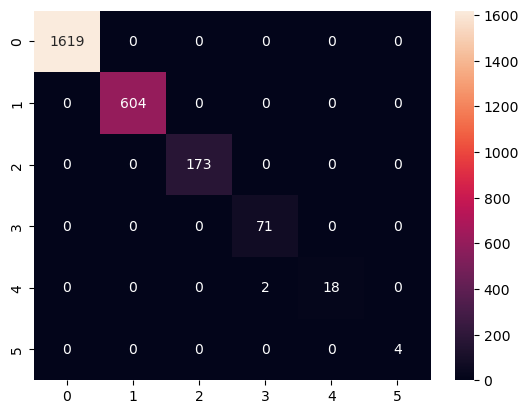

In [56]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

### Training Model 'x'

In [18]:
# Load the data
X, y = np.load('data/X_x.npy'), np.load('data/y_x.npy')
X.shape, y.shape

((508943, 28), (508943,))

In [20]:
# Split the data into training and testing
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.05)
x_train.shape, x_test.shape

((483495, 28), (25448, 28))

In [21]:
# Convert y into categories
y_train_cat, y_test_cat = to_categorical(y_train,6), to_categorical(y_test,6)
y_train_cat.shape, y_test_cat.shape

((483495, 6), (25448, 6))

In [24]:
# compile an untrained model
# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    verbose=1,
                    patience=10,
                    mode='min',
                    restore_best_weights=True)
model_x = make_model()
model_x.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 180)               5220      
                                                                 
 dense_1 (Dense)             (None, 64)                11584     
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 17,194
Trainable params: 17,194
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Adding class weights
total = y_train.shape[0]
count_0 = y_train[y_train==0].shape[0]
count_1 = y_train[y_train==1].shape[0]
count_2 = y_train[y_train==2].shape[0]
count_3 = y_train[y_train==3].shape[0]
count_4 = y_train[y_train==4].shape[0]
count_5 = y_train[y_train==5].shape[0]

weight_for_0 = (1/count_0)*(total/2.0)
weight_for_1 = (1/count_1)*(total/2.0)
weight_for_2 = (1/count_2)*(total/2.0)
weight_for_3 = (1/count_3)*(total/2.0)
weight_for_4 = (1/count_4)*(total/2.0)
weight_for_5 = (1/count_5)*(total/2.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2,
                3: weight_for_3, 4: weight_for_4, 5: weight_for_5}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))
print('Weight for class 4: {:.2f}'.format(weight_for_4))
print('Weight for class 5: {:.2f}'.format(weight_for_5))

Weight for class 0: 0.74
Weight for class 1: 2.14
Weight for class 2: 8.34
Weight for class 3: 23.75
Weight for class 4: 52.53
Weight for class 5: 190.80


In [28]:
# Train the model
EPOCHS = 20
history = model_x.fit(
            x_train,
            y_train_cat,
            batch_size=32,
            epochs=EPOCHS,
            callbacks=[early_stopping],
            validation_data=(x_test,y_test_cat),
            class_weight=class_weight)

Epoch 1/20


2023-05-18 04:38:25.180931: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-18 04:38:25.634652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15110/15110 [==============================] - ETA: 0s - loss: 0.3257 - tp: 466582.0000 - fp: 3225.0000 - tn: 2414250.0000 - fn: 16913.0000 - categorical_accuracy: 0.9787 - precision: 0.9931 - recall: 0.9650 - auc: 0.9996 - prc: 0.9984

2023-05-18 04:43:12.115767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15110/15110 [==============================] - 299s 20ms/step - loss: 0.3257 - tp: 466582.0000 - fp: 3225.0000 - tn: 2414250.0000 - fn: 16913.0000 - categorical_accuracy: 0.9787 - precision: 0.9931 - recall: 0.9650 - auc: 0.9996 - prc: 0.9984 - val_loss: 0.0036 - val_tp: 25435.0000 - val_fp: 13.0000 - val_tn: 127227.0000 - val_fn: 13.0000 - val_categorical_accuracy: 0.9995 - val_precision: 0.9995 - val_recall: 0.9995 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 2/20
15110/15110 [==============================] - 303s 20ms/step - loss: 0.0598 - tp: 482898.0000 - fp: 597.0000 - tn: 2416878.0000 - fn: 597.0000 - categorical_accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9999 - prc: 0.9998 - val_loss: 7.4162e-04 - val_tp: 25445.0000 - val_fp: 3.0000 - val_tn: 127237.0000 - val_fn: 3.0000 - val_categorical_accuracy: 0.9999 - val_precision: 0.9999 - val_recall: 0.9999 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 3/20
15110/15110 [==============================] - 304s 20ms/step - l

In [29]:
model_x.save('model_x2.h5')

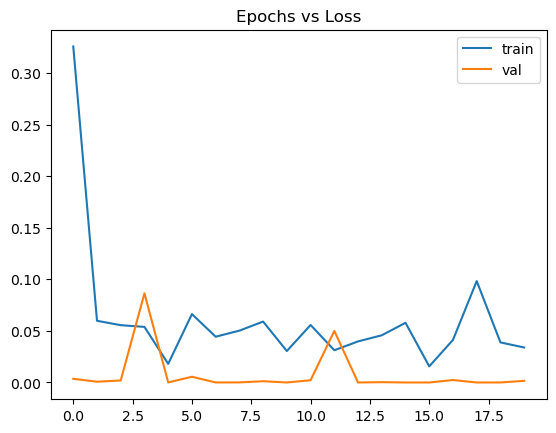

In [30]:
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='train')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label='val')
plt.title('Epochs vs Loss')
plt.legend()

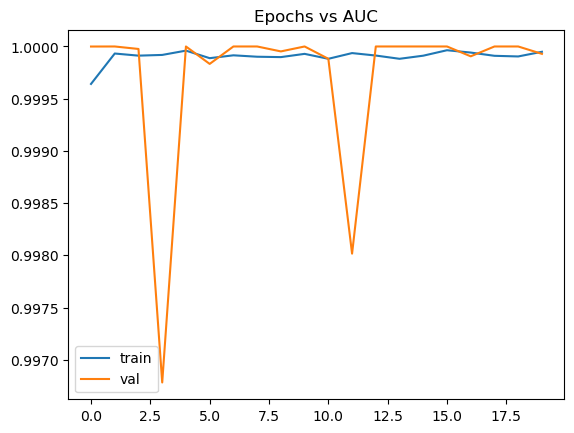

In [31]:
plt.plot(range(len(history.history['auc'])), history.history['auc'], label='train')
plt.plot(range(len(history.history['val_auc'])), history.history['val_auc'], label='val')
plt.title('Epochs vs AUC')
plt.legend()

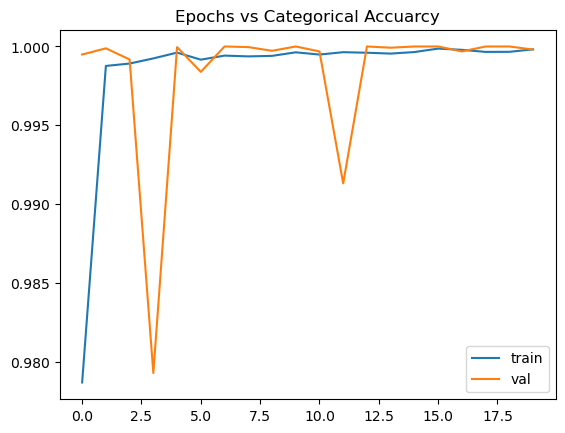

In [32]:
plt.plot(range(len(history.history['categorical_accuracy'])), history.history['categorical_accuracy'], label='train')
plt.plot(range(len(history.history['val_categorical_accuracy'])), history.history['val_categorical_accuracy'], label='val')
plt.title('Epochs vs Categorical Accuarcy')
plt.legend()

2023-05-18 06:23:44.961169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<Axes: >

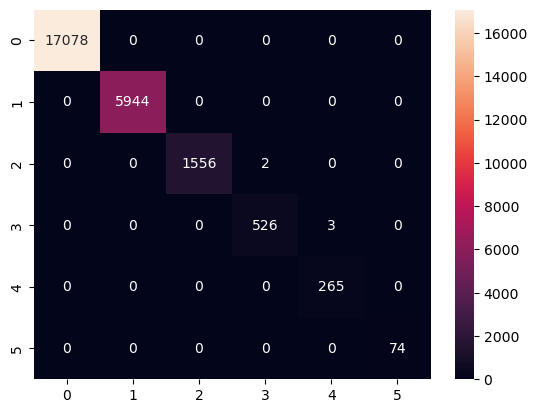

In [33]:
y_pred = np.argmax(model_x.predict(x_test, verbose=0), axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

### sklearn Training

In [31]:
# Saving the game
clf = MLPClassifier(solver='adam', hidden_layer_sizes=[180,100], max_iter=10000)
clf.fit(x_train, y_train.ravel())

MLPClassifier(hidden_layer_sizes=[180, 100], max_iter=10000)

Training can take upto ~4 mins with 30k training data

In [32]:
def analyse_model(model,x,y):
    y_pred = model.predict(x)
    print(f'Accuracy : {(y_pred==y).sum()/y.shape[0]:5f}')
    print(f'loss : {model.loss_}')
    plt.plot(range(len(model.loss_curve_)), model.loss_curve_)

Accuracy : 0.675776
loss : 0.08355867060283169


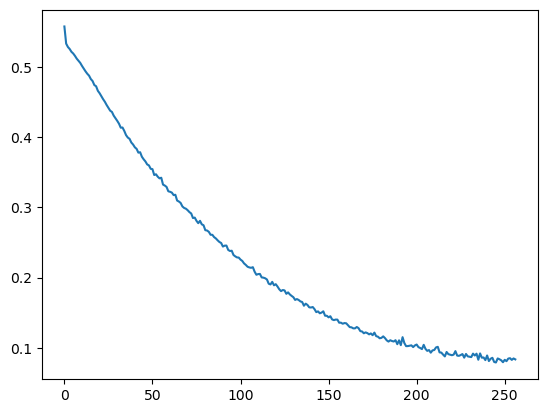

In [33]:
# Test data
analyse_model(clf, x_test, y_test.ravel())

Accuracy : 0.670186
loss : 0.08720085297688489


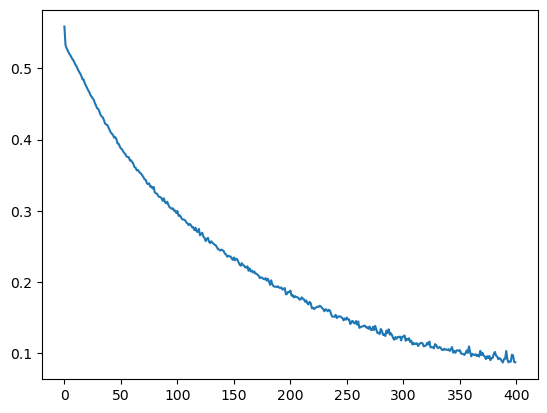

In [50]:
# Test data
analyse_model(clf, x_test, y_test.ravel())

Accuracy : 0.968461
loss : 0.08355867060283169


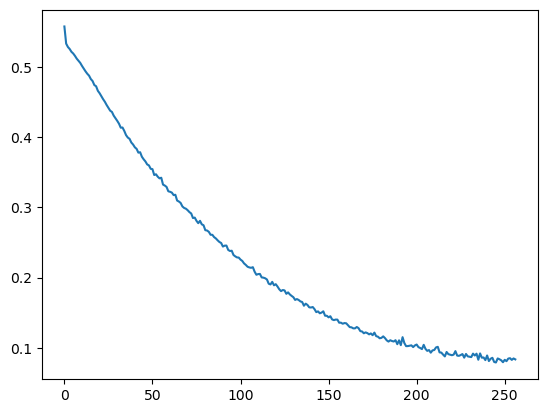

In [34]:
# Train data
analyse_model(clf, x_train, y_train.ravel())

Accuracy : 0.969841
loss : 0.08720085297688489


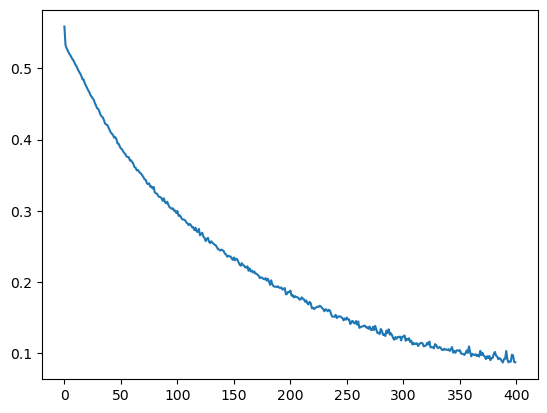

In [51]:
# Train data
analyse_model(clf, x_train, y_train.ravel())

Accuracy : 0.939876
loss : 0.08720085297688489


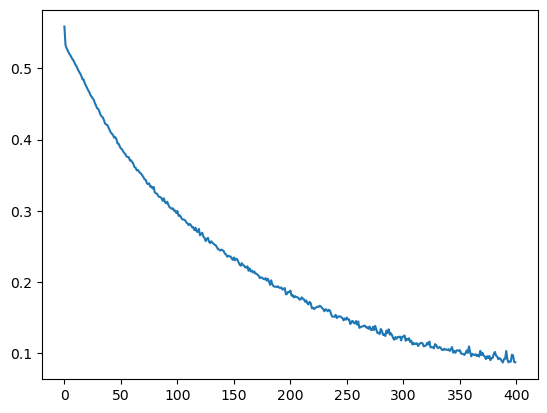

In [53]:
# fit on entire set
#clf.fit(X,y.ravel())
analyse_model(clf, X_proc,y.ravel())

Accuracy : 0.986600
loss : 0.06009667600846608


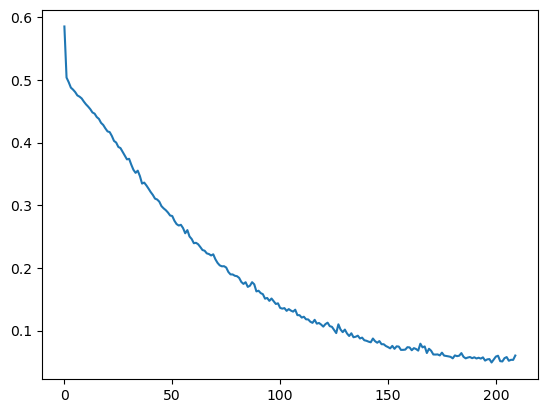

In [32]:
# Test data
analyse_model(clf, x_test, y_test.ravel())

# Part II

## Make a model play

In [34]:
alak_model = Alak(verbose=False)

#### Load the model

In [35]:
model_o = tf.keras.models.load_model('tournament/model_o_tf.h5')
model_x = tf.keras.models.load_model('model_x2.h5')

#### Model 'o' performance

In [7]:
model_win = 0
n_games = 500
winner_side = 'o'
for _ in tqdm(range(n_games)):
    cur_winner, cur_rounds = alak_model.play(model=(None,model), allow_suicide=(True,False))
    if cur_winner == winner_side:
        model_win+=1

100%|█████████████████████████████████████████| 500/500 [01:14<00:00,  6.70it/s]


In [8]:
print(f'{winner_side} wins : {model_win/n_games*100:.2f}% random games')

o wins : 99.80% random games


#### Model 'x' performance

In [41]:
model_win = 0
n_games = 1000
winner_side = 'x'
for _ in tqdm(range(n_games)):
    cur_winner, cur_rounds,_,_ = alak_model.play(model=(model_x,None), allow_suicide=(False,True))
    if cur_winner == winner_side:
        model_win+=1

100%|███████████████████████████████████████| 1000/1000 [02:23<00:00,  6.95it/s]


In [42]:
print(f'{winner_side} wins : {model_win/n_games*100:.2f}% random games')

x wins : 98.10% random games


## Play interactively

In [44]:
from Alak2 import Alak
alak = Alak(verbose=True)

In [45]:
model_o = tf.keras.models.load_model('tournament/model_o_tf.h5')
model_x = tf.keras.models.load_model('model_x2.h5')

### Side 'x'

In [46]:
alak.play(interact=(True, True), model=(model_x,None),allow_suicide=((False,True)))

2023-05-18 06:30:30.512333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Board : x x x x x _ _ _ _ o o o o o
        0 1 2 3 4 5 6 7 8 9 A B C D
x : Making a move
Moving 0=>5
Board : _ x x x x x _ _ _ o o o o o
        0 1 2 3 4 5 6 7 8 9 A B C D
o : Making a move
Available pos : [ 9 10 11 12 13]


KeyboardInterrupt: Interrupted by user

### Side 'o'

In [8]:
alak.play(interact=(True, True), model=(None, model_o),allow_suicide=((True,False)))

Board : x x x x x _ _ _ _ o o o o o
        0 1 2 3 4 5 6 7 8 9 A B C D
x : Making a move
Available pos : [0 1 2 3 4]


KeyboardInterrupt: Interrupted by user